### Variational Inference for Probabilistic PCA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### PPCA model components:
+ Latent variable $\mathbf{z}_n \in \mathbb{R}^{K}$:  $\mathbf{z}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
+ Model parameters $\mathbf{W} \in \mathbb{R}^{DxK}$, which is the principal components
    $\mathbf{W} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
+ Modeled data $\mathbf{x}_n \in \mathbb{R}^{D}$ (conditioned on the latent vars): $\mathbf{x}_n | \mathbf{z}_n \sim  \mathcal{N}(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I})$

In [2]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    z = ed.Normal(
        loc=tf.zeros([latent_dim, num_datapoints]),
        scale=tf.ones([latent_dim, num_datapoints]),
        name='z'
    )
    
    w = ed.Normal(
        loc=tf.zeros([data_dim, latent_dim]),
        scale=2.0 * tf.ones([data_dim, latent_dim]),
        name='w'
    )
    
    x = ed.Normal(
        loc=tf.matmul(w, z),
        scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
        name='x'
    )
    
    return x, (w, z)

log_joint_ppca_model = ed.make_log_joint_fn(ppca_model)

### Generative process
Goal: generate data from the generative model,
    then use this data to fit the model to inference the latent vars

In [7]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

generative_model = ppca_model(data_dim=data_dim, latent_dim=latent_dim,
                              num_datapoints=num_datapoints,
                              stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
    x_train, (actual_w, actual_z) = sess.run(generative_model)
    
print('Actual axes: ')
print(actual_w)

Actual axes: 
[[-4.1910744]
 [ 3.1450622]]


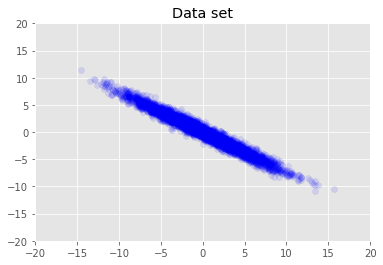

In [8]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

### Variational Inference:
Learn the distribution of the parameters `W` and `Z` from the observed data `X` using VI method.
The goal is to approximate the posterior prob. dist. $p(W, Z | X)$ but it is not possible.

VI method offers a mechanism to approximate the posterior prob. dist. by using a family of variational distribution $q(W, Z; \lambda)$.

The problem is thus:
$$
    \lambda = argmin_{\lambda} KL(q({W, Z; \lambda}) || p(W, Z | X))
$$

According to [this guide](http://edwardlib.org/tutorials/klqp), this problem is equivalent to:
$$
    \lambda = argmin_{\lambda} \mathbb{E}_{q({W, Z; \lambda})}[\log p(W, Z, X) - \log q({W, Z; \lambda})]
$$

The first term $\mathbb{E}_{q({W, Z; \lambda})}[\log p(W, Z, X)]$ is called **energy**,
the second term $ - \mathbb{E}_{q({W, Z; \lambda})}[\log q({W, Z; \lambda})]$ is **entropy** of $q$.

The first term: we have had `log_joint_ppca_model` defined above.
For the second term, we need to define a _variational model_ $q$.

$q$ constaints two random vars, so for specifing $q$, we need to find out the characteristiques of each random var (mean and variance for each $W$ and $Z$).

In [44]:
# because we've run the computational graph of TF once,
# before continuing to run the TF code, we MUST reset the computational graph
tf.reset_default_graph()

In [45]:
# for the first term: define an energy function
def energy_func(qw, qz):
    return log_joint_ppca_model(
        data_dim=data_dim, latent_dim=latent_dim,
        num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints,
        x=x_train, w=qw, z=qz
    )

In [46]:
# for the second term:
# first, define the variational model of two variable W and Z
def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name='qw')
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name='qz')
    return qw, qz

log_joint_variational_model = ed.make_log_joint_fn(variational_model)

# then, define the variables for W and Z (note to specify the default values for them)
qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))

# finally, define the entropy function
def entropy_func(qw, qz):
    return - log_joint_variational_model(
        qw_mean=qw_mean, qw_stddv=qw_stddv, qz_mean=qz_mean, qz_stddv=qz_stddv,
        qw=qw, qz=qz
    )

In [47]:
# once we have the `variational_model`
# use this model to specify the variational variables `qw` and `qz`

qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                           qz_mean=qz_mean, qz_stddv=qz_stddv)

# define how to calculate the energy and entropy
energy = energy_func(qw, qz)
entropy = entropy_func(qw, qz)

# define an ELBO objective function
elbo = energy + entropy

# define how to maximize the ELBO (or minimize -elbo)
optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train_process = optimizer.minimize( - elbo)

In [48]:
init_process = tf.global_variables_initializer()
t = []
num_epochs = 100

with tf.Session() as sess:
    # first, make sure to init all varaibles
    sess.run(init_process)
    
    # then run the training process
    for i in range(num_epochs):
        sess.run(train_process)
        
        # log the value of ELBO objective function
        if i % 5 == 0:
            t.append(sess.run([elbo]))
        
    # after finishing the training, make sure to collect the target parameters
    w_mean_vi = sess.run(qw_mean)
    w_stddv_vi = sess.run(qw_stddv)
    z_mean_vi = sess.run(qz_mean)
    z_stddv_vi = sess.run(qz_stddv)

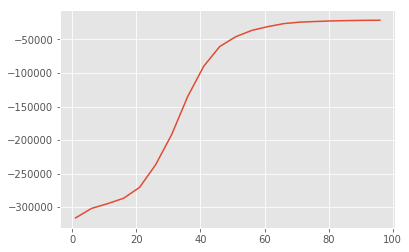

In [49]:
# how the ELBO looks like?
plt.plot(range(1, num_epochs, 5), t)
plt.show()

In [50]:
# what is the value of inferred mean `W` (and compare to the `actual_w`)
print('Actual axes: ')
print(actual_w)

print('Inferred axes: ')
print(w_mean_vi)
print('Std of W: ')
print(w_stddv_vi)

# print('Actural z:',  actual_z)
# print('Inferred z:', z_mean_vi, z_stddv_vi)

Actual axes: 
[[-4.1910744]
 [ 3.1450622]]
Inferred axes: 
[[ 2.6424184]
 [-1.9918554]]
Std of W: 
[[0.01316922]
 [0.03143704]]


In [52]:
# Now, to compare the actual data `x_train` with the data generated
# with the inferred params above, let re-create a generative process
# in which the assumped params are replaced by the inferred params,
# and then run the new generative process to create the new generated data

tf.reset_default_graph()

def replace_latents(w=actual_w, z=actual_z):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
          rv_kwargs["value"] = w
        elif name == "z":
          rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)
    return interceptor

with ed.interception(replace_latents(w_mean_vi, z_mean_vi)):
    new_generative_process = ppca_model(
        data_dim=data_dim, latent_dim=latent_dim,
        num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints
    )
    
with tf.Session() as sess:
    x_generated, _ = sess.run(new_generative_process)

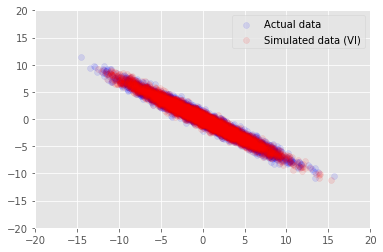

In [53]:
# visually compare
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()